In [806]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import numpy as np
import math

In [807]:
train_df = pd.read_csv('database/train.csv', index_col=0)
test_df = pd.read_csv('database/test.csv', index_col=0)
train_df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


# Train Validation Split

In [808]:
original_df = train_df.drop(columns=['id'])
test_df = test_df.drop(columns=['id'])

In [809]:
train_df, validation_df = train_test_split(original_df,test_size= 0.25, stratify=original_df['satisfaction'])

print('original_df: ',len(original_df))
print('train_df size: ', len(train_df), "| validation_df size:", len(validation_df))
print(f'train_df: {len(train_df)/len(original_df)}%', f"| validation_df: {len(validation_df)/len(original_df)}%",)

original_df:  103904
train_df size:  77928 | validation_df size: 25976
train_df: 0.75% | validation_df: 0.25%


# Outliers

<Axes: >

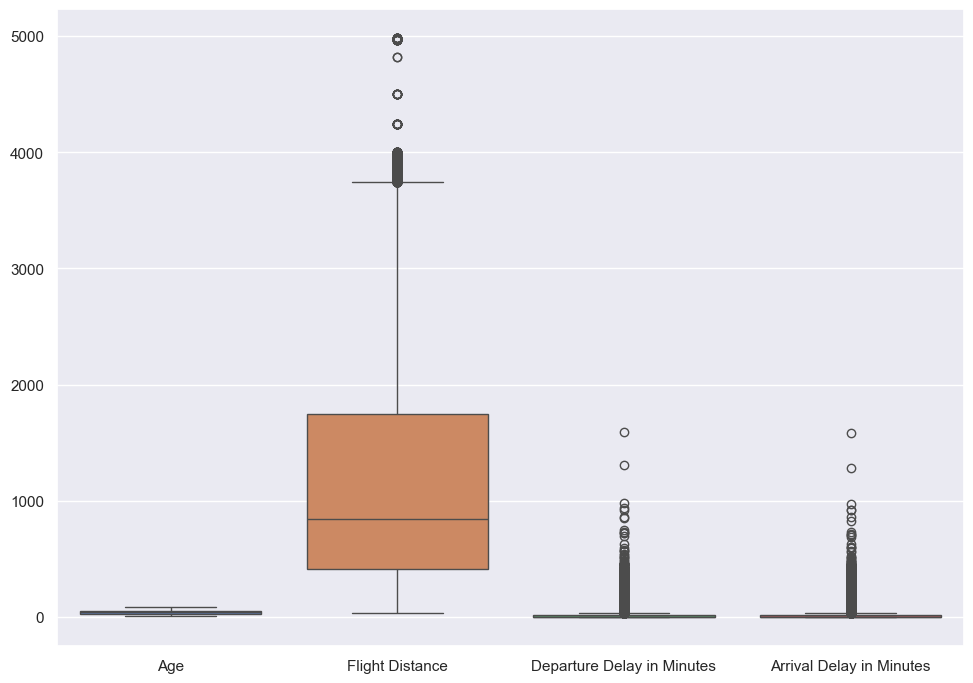

In [810]:
train_df.reset_index(drop=True, inplace=True)

cols = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

sns.set_theme(rc={'figure.figsize':(11.7,8.27)})

sns.boxplot(data=train_df[cols])

Original DataFrame Shape: (77928, 23)
DataFrame Shape after Removing Outliers: (76193, 23)
Columns with z-score > 3:  ['Age', 'Flight Distance', 'Departure Delay in Minutes']


<Axes: >

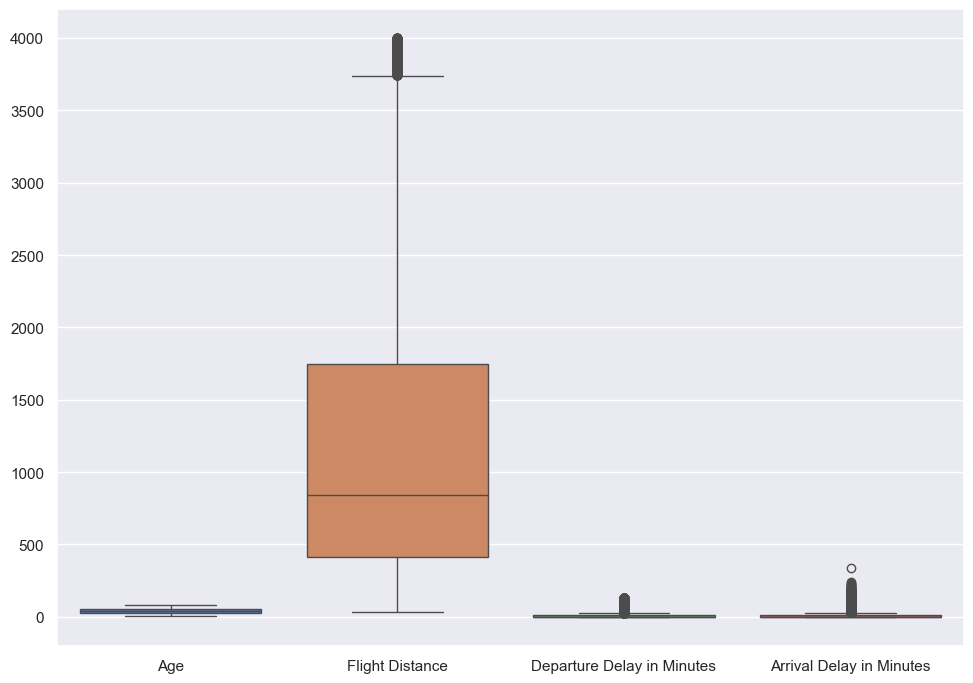

In [811]:
print("Original DataFrame Shape:", train_df.shape)
z_score_col = []
for cl in cols:
    z = np.abs(stats.zscore(train_df[cl]))
    outlier_set = (np.where(z > 3)[0])
    train_df = train_df.drop(index=outlier_set)
    train_df.reset_index(drop=True, inplace=True)
    if len(outlier_set > 0):
        z_score_col.append(cl)
        
    
print("DataFrame Shape after Removing Outliers:", train_df.shape)
print('Columns with z-score > 3: ', z_score_col)

sns.boxplot(data=train_df[cols])

# Enconding

## One Hot Enconding

In [812]:
one_hot_encoder_vars = ['Type of Travel', 'Gender', 'Customer Type']
validation_df = pd.get_dummies(validation_df, columns=one_hot_encoder_vars, drop_first=True)
train_df = pd.get_dummies(train_df, columns=one_hot_encoder_vars, drop_first=True)
train_df[['Type of Travel_Personal Travel', 'Gender_Male',  'Customer Type_disloyal Customer']]

,Type of Travel_Personal Travel,Gender_Male,Customer Type_disloyal Customer
0,False,True,True
1,False,True,False
2,True,False,False
3,True,False,False
4,True,False,False
...,...,...,...
76188,True,False,False
76189,False,False,False
76190,False,False,True
76191,False,True,False


# Ordinal Enconding

In [813]:
classes_dict = {
    'Eco': 0,
    'Eco Plus': 1,
    'Business': 2
}
def ord_encode(x):
    return classes_dict[x]

ordinal_encoder_vars = ['Class']
print('Before Encoding: ', train_df[ordinal_encoder_vars].values)
train_df[ordinal_encoder_vars] = train_df[ordinal_encoder_vars].map(ord_encode)
print('After Encoding: ', train_df[ordinal_encoder_vars].values)

Before Encoding:  [['Eco']
 ['Business']
 ['Eco']
 ...
 ['Eco']
 ['Business']
 ['Eco Plus']]
After Encoding:  [[0]
 [2]
 [0]
 ...
 [0]
 [2]
 [1]]


## Binning

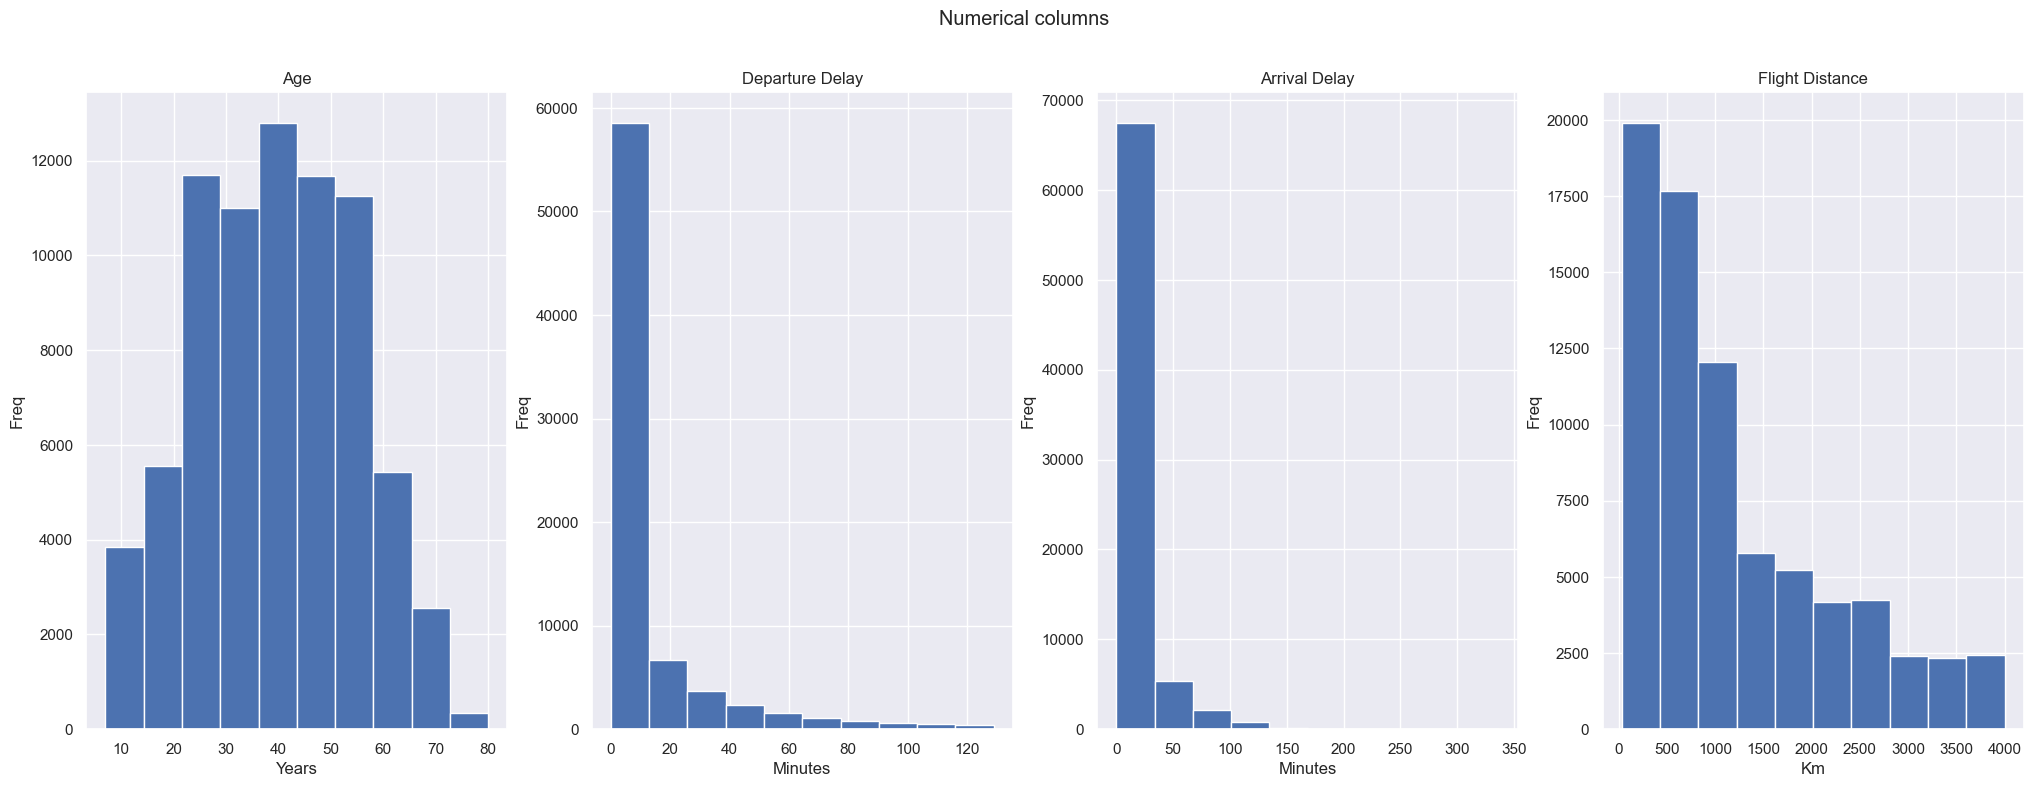

In [814]:
binning_vars = ['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Flight Distance']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)

fig.set_figwidth(25)
fig.suptitle('Numerical columns')

ax1.set_title('Age')
ax1.set(xlabel='Years', ylabel='Freq')
ax1.hist(train_df['Age'])

ax2.set_title('Departure Delay')
ax2.set(xlabel='Minutes', ylabel='Freq')
ax2.hist(train_df['Departure Delay in Minutes'])

ax3.set_title('Arrival Delay')
ax3.set(xlabel='Minutes', ylabel='Freq')
ax3.hist(train_df['Arrival Delay in Minutes'])

ax4.set_title('Flight Distance')
ax4.set(xlabel='Km', ylabel='Freq')
ax4.hist(train_df['Flight Distance'])

plt.show()

In [815]:
def binning(column: str, method: str):
    # 4 bins
    if method == 'distance':
        boundary = math.ceil((train_df[column].max()- train_df[column].min())/4)
    elif method == 'frequency':
        freq = len(train_df[column])/4
        print(freq)
        return
    
    print(f'{column} boundary to split: ', boundary)

    bins_means = [math.ceil(train_df[(train_df[column] >= boundary*i) & (train_df[column] < boundary*(i+1))][column].mean()) for i in range(4)]
    print('Bin means: ', bins_means)

    def binnign_method(age) -> int:

        if np.isnan(age):
            return np.nan
        
        if age < boundary:
            return bins_means[0]
        
        if age < 2*boundary:
            return bins_means[1]
        
        if age < 3*boundary:
            return bins_means[2]
        
        if age < 4*boundary:
            return bins_means[3]

    print(f'{column} before binning: ', train_df[column].head(5))
    train_df[column] = train_df[column].map(binnign_method)
    validation_df[column] = validation_df[column].map(binnign_method)
    print(f'{column} before binning: ', train_df[column].head(5))

### Age

In [816]:
binning(column='Age', method='distance')

Age boundary to split:  19
Bin means:  [14, 29, 47, 63]
Age before binning:  0    22
1    37
2     8
3    21
4    62
Name: Age, dtype: int64
Age before binning:  0    29.0
1    29.0
2    14.0
3    29.0
4    63.0
Name: Age, dtype: float64


### Departure Delay

In [817]:
binning(column='Departure Delay in Minutes', method='distance')

Departure Delay in Minutes boundary to split:  33
Bin means:  [4, 47, 81, 113]
Departure Delay in Minutes before binning:  0     0
1    85
2     0
3     0
4     5
Name: Departure Delay in Minutes, dtype: int64
Departure Delay in Minutes before binning:  0     4
1    81
2     4
3     4
4     4
Name: Departure Delay in Minutes, dtype: int64


### Arrival Delay

In [818]:
binning(column='Arrival Delay in Minutes', method='distance')

Arrival Delay in Minutes boundary to split:  85
Bin means:  [9, 107, 192, 337]
Arrival Delay in Minutes before binning:  0     6.0
1    83.0
2     0.0
3     0.0
4     2.0
Name: Arrival Delay in Minutes, dtype: float64
Arrival Delay in Minutes before binning:  0    9.0
1    9.0
2    9.0
3    9.0
4    9.0
Name: Arrival Delay in Minutes, dtype: float64


In [819]:
train_df.describe()

,Age,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,75978.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,76193.000000,75983.000000
mean,39.974506,1.026853,1187.051895,2.730631,3.059796,2.753678,2.975076,3.205859,3.248566,3.441760,3.361674,3.388080,3.345097,3.633195,3.303204,3.649259,3.285892,10.756434,11.499520
std,14.050906,0.962966,993.369870,1.326875,1.524249,1.396502,1.276615,1.329102,1.348694,1.318502,1.334976,1.289067,1.319608,1.182449,1.263573,1.173627,1.312384,20.476518,15.698952
min,14.000000,0.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,4.000000,9.000000
25%,29.000000,0.000000,413.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,4.000000,9.000000
50%,47.000000,1.000000,842.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,4.000000,9.000000
75%,47.000000,2.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,4.000000,9.000000
max,63.000000,2.000000,4000.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,113.000000,337.000000


# Missing Values

In [820]:
# sns.heatmap(train_df.isnull(), cbar=False)
print(train_df.columns[train_df.isnull().any()])
columns = train_df.columns[train_df.isnull().any()]
train_df[columns] = train_df[columns].fillna(train_df[columns].median())
print(train_df.columns[train_df.isnull().any()])

Index(['Age', 'Arrival Delay in Minutes'], dtype='object')
Index([], dtype='object')


In [821]:
# sns.heatmap(validation_df.isnull(), cbar=False)
print(validation_df.columns[validation_df.isnull().any()])
columns = validation_df.columns[validation_df.isnull().any()]

#substituindo pela mediana do conjunto de teste
validation_df[columns] = validation_df[columns].fillna(train_df[columns].median())
validation_df.columns[validation_df.isnull().any()]

Index(['Age', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'], dtype='object')


Index([], dtype='object')

# Min Max Scaling TODO

# OverSampling

In [822]:
def overSampling(x, y):
  ros = RandomOverSampler(
    sampling_strategy='auto',
    random_state=0,
  )
  return ros.fit_resample(x,y)

def printClassDistributionRate(y):
  print('total: ',len(y))
  print('satisfied: ', len(y[y['satisfaction'] == 'satisfied']), ' not satisfied: ', len(y[y['satisfaction'] != 'satisfied']))
  print('satisfied: ', len(y[y['satisfaction'] == 'satisfied'])/len(y), ' not satisfied: ', len(y[y['satisfaction'] != 'satisfied'])/len(y), '\n')

In [823]:
x_train_df = train_df.drop(columns='satisfaction')
y_train_df = train_df[['satisfaction']]

printClassDistributionRate(y_train_df)

x_train_df, y_train_df = overSampling(x_train_df, y_train_df )

printClassDistributionRate(y_train_df)

total:  76193
satisfied:  33112  not satisfied:  43081
satisfied:  0.4345806045174754  not satisfied:  0.5654193954825246 

total:  86162
satisfied:  43081  not satisfied:  43081
satisfied:  0.5  not satisfied:  0.5 



In [824]:
x_validation_df = validation_df.drop(columns='satisfaction')
y_validation_df = validation_df[['satisfaction']]

printClassDistributionRate(y_validation_df)

x_validation_df, y_validation_df = overSampling(x_validation_df, y_validation_df )

printClassDistributionRate(y_validation_df)

total:  25976
satisfied:  11256  not satisfied:  14720
satisfied:  0.43332306744687404  not satisfied:  0.566676932553126 

total:  29440
satisfied:  14720  not satisfied:  14720
satisfied:  0.5  not satisfied:  0.5 



# Correlation Matrix

In [825]:
corr = x_train_df.corr(method='spearman')
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 18))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot = True, mask=mask, cmap="YlGnBu", center=0,
            square=True, linewidths=.5)

C:\Users\lucca\AppData\Local\Temp\ipykernel_14468\4006740798.py:3: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  mask = np.zeros_like(corr, dtype=np.bool)


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations